## Load libraries

In [15]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import pickle

# Libraries to cluster data
from gensim.corpora import Dictionary
# from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.cm as cm
from cluster_visualization_helper import (
    compute_cluster_visualization,
    visualize_cluster)  # user-defined functions
from pprint import pprint

# Libraries for evaluation
from sklearn import metrics
from gensim.models import CoherenceModel
# from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric

# Libraries for monitoring operation process
from datetime import datetime
from tqdm import tqdm
# import logging
# import re

## Configurate and declare global variables

In [16]:
os_name = os.name

if os_name == 'nt':
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

elif os_name == 'posix':
    """Linux platform"""
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
RESULT_DIR = BASE_DIR + "RESULTS/"

SEED = 6886
%matplotlib inline

## Import data

In [17]:
skill_embeddings = np.load(OUTPUT_DIR + "skill_feat_halfsize_embeddings.npy")
skill_embeddings.shape

(257205, 150)

In [18]:
skill_docs = pd.read_csv(
    OUTPUT_DIR + "skill_tokens_long_df.csv",
    converters={
        "skill_token": ast.literal_eval,
    },
    dtype={
        "key_id": int,
        "skill_id": int,
        "job_id": int,
        "column_type": str,
        "skill": str,
        "skill_lemma": str
    }
)
skill_docs.shape

(257205, 9)

In [19]:
skill_docs

,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]"
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]"
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]"
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]"
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]"
...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]"
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]"
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]"
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]"


## Clustering data

### LDA

In [20]:
# Create doc list of clean job title
doc_list = skill_docs["skill_lemma"].values.tolist()
pprint(doc_list[:10])

# Create corpus (list of tokens per document)
skill_corpus = skill_docs["skill_token"].values.tolist()
pprint(skill_corpus[:10])

# Create Dictionary
id2word = Dictionary(skill_corpus)

# Term Document Frequency
lda_corpus = [id2word.doc2bow(text) for text in skill_corpus]
pprint(lda_corpus[:3])

['ameria investment consult company',
 'require high level',
 'provide highly responsible',
 'complex staff assistance',
 'chief financial officer',
 'irex currently seek',
 'position report directly',
 'cc program manager',
 'yerevan office',
 'community connection']
[['ameria', 'investment', 'consult', 'company'],
 ['require', 'high', 'level'],
 ['provide', 'highly', 'responsible'],
 ['complex', 'staff', 'assistance'],
 ['chief', 'financial', 'officer'],
 ['irex', 'currently', 'seek'],
 ['position', 'report', 'directly'],
 ['cc', 'program', 'manager'],
 ['yerevan', 'office'],
 ['community', 'connection']]
[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1)]]


In [21]:
def build_lda_model(dictionary, corpus, n_topics, alpha, beta):
    """
    Build LDA Topic model

    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    n_topics: number of topics
    alpha: Dirichlet hyperparameter alpha (Document-Topic Density)
    beta: Dirichlet hyperparameter beta (Word-Topic Density)

    Returns:
    -------
    model: LDA topic models
    """

#     model = LdaModel(
    model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=SEED,
#         update_every=1,
#         chunksize=1000,
        passes=50,
        alpha=alpha,
        eta=beta,
        iterations=100,
        minimum_probability=0,
        workers=6
    )

    return model

In [27]:
# Preparing hyperparameters for tuning
# grid = {}
# grid["Validation_Set"] = {}

# Topics range
# min_topics = 2
# max_topics = 101
# step_size = 10
# topics_range = range(min_topics, max_topics, step_size)
topic_range = [5, 10, 15, 20, 25, 50, 75, 100, 150, 200]
# topic_range = [150, 200]

# Alpha parameter
alpha_range = [0.001, 0.01, 0.25, 0.5]
# alpha_range = [0.001]
# alpha.append("symmetric")
# alpha.append("asymmetric")

# Beta parameter
beta_range = [0.001, 0.01, 0.25, 0.5]
# beta_range = [0.001]
# beta.append("symmetric")

# Validation sets
# num_of_docs = len(lda_corpus)
# corpus_sets = [ClippedCorpus(lda_corpus, int(num_of_docs * 0.75)), lda_corpus]
# corpus_title = ["75% Corpus", "100% Corpus"]
tuning_result = {
    #     "Validation_Set_no": [],
    #     "Validation_Set": [],
    "n_topics": [],
    #     "Alpha_num": [],
    "alpha": [],
    #     "Beta_num": [],
    "beta": [],
    "duration": [],
}

model_list = []

In [28]:
# len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)
print(topic_range)
print(alpha_range)
print(beta_range)
print(
    len(topic_range),
    len(alpha_range),
    len(beta_range),
    len(topic_range) * len(alpha_range) * len(beta_range),
)

[150, 200]
[0.001, 0.01, 0.25, 0.5]
[0.001, 0.01, 0.25, 0.5]
2 4 4 32


In [29]:
# Tuning LDA to find optimal number of topics

# iterate through number of topics
for n_topics in tqdm(
    iterable=topic_range,
    desc="LDA tuning",
    total=len(topic_range) * len(alpha_range) * len(beta_range),
):
    # iterate through alpha values
    for ida, alpha in enumerate(alpha_range):
        # iterare through beta values
        for idb, beta in enumerate(beta_range):
            if (n_topics == 150 and alpha < 0.5):
                print('Training done')
            else:
                # Train model
                starttime = datetime.now()
                print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))
                print("n_topics =", n_topics)
                print("alpha =", alpha)
                print("beta =", beta)

                # get the coherence score and perplexity for the given parameters
                clusterer = build_lda_model(
                    dictionary=id2word,
                    corpus=lda_corpus,
                    n_topics=n_topics,
                    alpha=alpha,
                    beta=beta,
                )

                endtime = datetime.now()
                print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
                print("Duration", endtime - starttime)

                #             cv_score, perplexity = compute_evaluation_metrics(
                #                 clusterer,
                #                 corpus=lda_corpus,
                #                 dictionary=id2word,
                #                 texts=title_corpus,
                #             )

                # Save model
                pickle.dump(
                    clusterer,
                    open(
                        OUTPUT_DIR
                        + "lda/"
                        + "skill_lda_model_n_topics-"
                        + str(n_topics)
                        + "_alpha-"
                        + str(alpha)
                        + "_beta-"
                        + str(beta)
                        + ".pkl",
                        "wb",
                    ),
                )

                model_list.append(clusterer)

                # Save the model results
                #             tuning_result["Validation_Set_no"].append(i)
                #             model_results["Validation_Set"].append(corpus_title[i])
                tuning_result["n_topics"].append(n_topics)
                #             tuning_result["Alpha_num"].append(ida)
                tuning_result["alpha"].append(alpha)
                #             tuning_result["Beta_num"].append(idb)
                tuning_result["beta"].append(beta)
                #             tuning_result["coherence"].append(cv_score)
                #             tuning_result["perplexity"].append(perplexity)
                tuning_result["duration"].append(
                    round((endtime - starttime).seconds / 60, 4)
                )

#             pbar.update(1)
# pbar.close()

LDA tuning:   0%|                                                                               | 0/32 [00:00<?, ?it/s]

Training done
Training done
Training done
Training done
Training done
Training done
Training done
Training done
Training done
Training done
Training done
Training done
Start 2021-05-21 00:10:30.291514
n_topics = 150
alpha = 0.5
beta = 0.001
End 2021-05-21 00:26:31.320074
Duration 0:16:01.028560
Start 2021-05-21 00:26:31.491078
n_topics = 150
alpha = 0.5
beta = 0.01
End 2021-05-21 00:43:18.111215
Duration 0:16:46.620137
Start 2021-05-21 00:43:18.127209
n_topics = 150
alpha = 0.5
beta = 0.25
End 2021-05-21 00:57:38.621186
Duration 0:14:20.493977
Start 2021-05-21 00:57:38.636185
n_topics = 150
alpha = 0.5
beta = 0.5


LDA tuning:   3%|██                                                              | 1/32 [1:01:42<31:52:46, 3702.15s/it]

End 2021-05-21 01:12:12.413848
Duration 0:14:33.777663
Start 2021-05-21 01:12:12.443876
n_topics = 200
alpha = 0.001
beta = 0.001


c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\gensim\models\ldamodel.py:838: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


End 2021-05-21 01:33:13.644961
Duration 0:21:01.201085
Start 2021-05-21 01:33:13.746003
n_topics = 200
alpha = 0.001
beta = 0.01
End 2021-05-21 01:53:49.637357
Duration 0:20:35.891354
Start 2021-05-21 01:53:49.655361
n_topics = 200
alpha = 0.001
beta = 0.25
End 2021-05-21 02:13:18.512733
Duration 0:19:28.857372
Start 2021-05-21 02:13:18.528705
n_topics = 200
alpha = 0.001
beta = 0.5
End 2021-05-21 02:30:35.109800
Duration 0:17:16.581095
Start 2021-05-21 02:30:35.207612
n_topics = 200
alpha = 0.01
beta = 0.001
End 2021-05-21 02:47:07.329457
Duration 0:16:32.121845
Start 2021-05-21 02:47:07.437648
n_topics = 200
alpha = 0.01
beta = 0.01
End 2021-05-21 03:03:42.435803
Duration 0:16:34.998155
Start 2021-05-21 03:03:42.450779
n_topics = 200
alpha = 0.01
beta = 0.25
End 2021-05-21 03:20:13.526900
Duration 0:16:31.076121
Start 2021-05-21 03:20:13.614286
n_topics = 200
alpha = 0.01
beta = 0.5
End 2021-05-21 03:36:32.005974
Duration 0:16:18.391688
Start 2021-05-21 03:36:32.098359
n_topics = 200

LDA tuning:   6%|████                                                            | 2/32 [5:27:29<81:52:17, 9824.57s/it]

End 2021-05-21 05:37:59.421777
Duration 0:14:14.467171


In [30]:
def compute_evaluation_metrics(model, corpus, dictionary, texts):
    """
    Compute umass, c_v coherence and perplexity for various number of topics

    Parameters:
    ----------
    model: LDA topic model
    corpus: Gensim corpus
    dictionary: Gensim dictionary
    texts: List of input texts

    Returns:
    -------
    coherence_umass: UMASS Coherence value corresponding to the LDA model with respective number of topics
    coherence_cv: C_V Coherence value corresponding to the LDA model with respective number of topics
    perplexity_value: Perplexity value corresponding to the LDA model with respective number of topics
    """

    umass_coherence_model = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence="u_mass"
    )
    cv_model = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    perplexity_value = model.log_perplexity(corpus)
    coherence_umass = umass_coherence_model.get_coherence()
    coherence_cv = cv_model.get_coherence()

    return coherence_umass, coherence_cv, perplexity_value

In [31]:
# topic_range2 = [5, 10, 15, 20, 25, 50, 75, 100, 150]
# model_list2 = []
# tuning_result2 = {"n_topics": [], "alpha": [], "beta": [], "duration": []}

# for n_topics in topic_range2:
#     # iterate through alpha values
#     for ida, alpha in enumerate(alpha_range):
#         # iterare through beta values
#         for idb, beta in enumerate(beta_range):
#             if (n_topics > 150) or (n_topics == 150 and alpha == 0.5):
#                 print('No appending!')
#             else:
#                 clusterer = pickle.load(
#                     open(
#                         OUTPUT_DIR
#                         + "lda/"
#                         + "skill_lda_model_n_topics-"
#                         + str(n_topics)
#                         + "_alpha-"
#                         + str(alpha)
#                         + "_beta-"
#                         + str(beta)
#                         + ".pkl",
#                         "rb",
#                     ),
#                 )
#                 model_list2.append(clusterer)

#                 # Save the model results
#                 tuning_result2["n_topics"].append(n_topics)
#                 tuning_result2["alpha"].append(alpha)
#                 tuning_result2["beta"].append(beta)
#                 tuning_result2["duration"].append(0)

No appending!
No appending!
No appending!
No appending!


In [32]:
# len(model_list2)

140

In [33]:
# tuning_result2_df = pd.DataFrame(tuning_result2)
# tuning_result2_df

,n_topics,alpha,beta,duration
0,5,0.001,0.001,0
1,5,0.001,0.010,0
2,5,0.001,0.250,0
3,5,0.001,0.500,0
4,5,0.010,0.001,0
...,...,...,...,...
135,150,0.010,0.500,0
136,150,0.250,0.001,0
137,150,0.250,0.010,0
138,150,0.250,0.250,0


In [57]:
# model_list1 = model_list.copy()
# model_list = model_list2.copy()
# model_list.extend(model_list1)
# len(model_list), len(model_list2), len(model_list1)

(160, 140, 20)

In [51]:
# tuning_result1 = tuning_result.copy()
# full_tuning_result_df = pd.concat(
#     (pd.DataFrame(tuning_result2), pd.DataFrame(tuning_result)), axis=0
# )
# # (
# #     len(full_tuning_result),
# #     len(tuning_result2),
# #     len(tuning_result),
# #     len(list(full_tuning_result.keys())),
# #     len(list(tuning_result2.keys())),
# #     len(list(tuning_result.keys())),
# #     list(full_tuning_result.values())[0],
# # )
# full_tuning_result_df

,n_topics,alpha,beta,duration
0,5,0.001,0.001,0.0000
1,5,0.001,0.010,0.0000
2,5,0.001,0.250,0.0000
3,5,0.001,0.500,0.0000
4,5,0.010,0.001,0.0000
...,...,...,...,...
15,200,0.250,0.500,14.6500
16,200,0.500,0.001,15.9667
17,200,0.500,0.010,16.1000
18,200,0.500,0.250,13.8167


In [ ]:
# tuning_result = full_tuning_result_df.to_dict(orient='list')
# # tuning_result

In [58]:
tuning_result["coherence_umass"] = []
tuning_result["coherence_cv"] = []
tuning_result["perplexity"] = []

for idx, i in tqdm(
    desc="Computing LDA Coherence and Perplexity",
    total=len(model_list),
    iterable=enumerate(model_list),
):
    umass_score, cv_score, perplexity = compute_evaluation_metrics(
        model_list[idx],
        corpus=lda_corpus,
        dictionary=id2word,
        texts=skill_corpus,
    )
    tuning_result["coherence_umass"].append(umass_score)
    tuning_result["coherence_cv"].append(cv_score)
    tuning_result["perplexity"].append(perplexity)

Computing LDA Coherence and Perplexity:  60%|███████████████████████▍               | 96/160 [1:05:02<47:42, 44.73s/it]c:\users\pinkavivo\appdata\local\programs\python\python38\lib\site-packages\gensim\models\ldamodel.py:838: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words
Computing LDA Coherence and Perplexity: 100%|██████████████████████████████████████| 160/160 [2:03:57<00:00, 46.49s/it]


In [59]:
# Display tuning results
tuning_result_df = pd.DataFrame(tuning_result)
tuning_result_df

,n_topics,alpha,beta,duration,coherence_umass,coherence_cv,perplexity
0,5,0.001,0.001,0.0000,-11.136685,0.479345,-59.475535
1,5,0.001,0.010,0.0000,-11.442648,0.484561,-15.324596
2,5,0.001,0.250,0.0000,-11.699154,0.498702,-7.761182
3,5,0.001,0.500,0.0000,-11.150186,0.484575,-7.401947
4,5,0.010,0.001,0.0000,-11.326147,0.485206,-56.461540
...,...,...,...,...,...,...,...
155,200,0.250,0.500,14.6500,-17.584732,0.583610,-8.583866
156,200,0.500,0.001,15.9667,-18.286749,0.533660,-100.400246
157,200,0.500,0.010,16.1000,-18.299788,0.535354,-16.023929
158,200,0.500,0.250,13.8167,-17.712221,0.476023,-7.930720


In [60]:
# Save tuning results
tuning_result_df.to_csv(
    RESULT_DIR + "lda/" + "skill_lda_tuning_result.csv", index=False
)

In [61]:
# Combine model sets
tuple_objects = (
    model_list,
    tuning_result,
)
len(tuple_objects), len(tuple_objects[0])

(2, 160)

In [62]:
# Save tuple of model sets
pickle.dump(
    tuple_objects, open(RESULT_DIR + "lda/" + "skill_lda_model_tuning_list.pkl", "wb")
)

In [63]:
# List of markers for subplots
marker_dict = {
#     ".": "point",
#     ",": "pixel",
    "o": "circle",
    "v": "triangle_down",
    "^": "triangle_up",
    "<": "triangle_left",
    ">": "triangle_right",
    "1": "tri_down",
    "2": "tri_up",
    "3": "tri_left",
    "4": "tri_right",
    "8": "octagon",
    "s": "square",
    "p": "pentagon",
    "*": "star",
    "h": "hexagon1",
    "H": "hexagon2",
    "+": "plus",
    "x": "x",
    "D": "diamond",
    "d": "thin_diamond",
    "|": "vline",
    "_": "hline",
    "P": "plus_filled",
    "X": "x_filled",
    0: "tickleft",
    1: "tickright",
    2: "tickup",
    3: "tickdown",
    4: "caretleft",
    5: "caretright",
    6: "caretup",
    7: "caretdown",
    8: "caretleftbase",
    9: "caretrightbase",
    10: "caretupbase",
    11: "caretdownbase",
}
marker_list = list(marker_dict.keys())

## Evaluation metrics

#### Topic Coherence

<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(1, 2, 1)
<ipython-input-64-dc66f18108fb>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(1, 2, 2)
<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be 

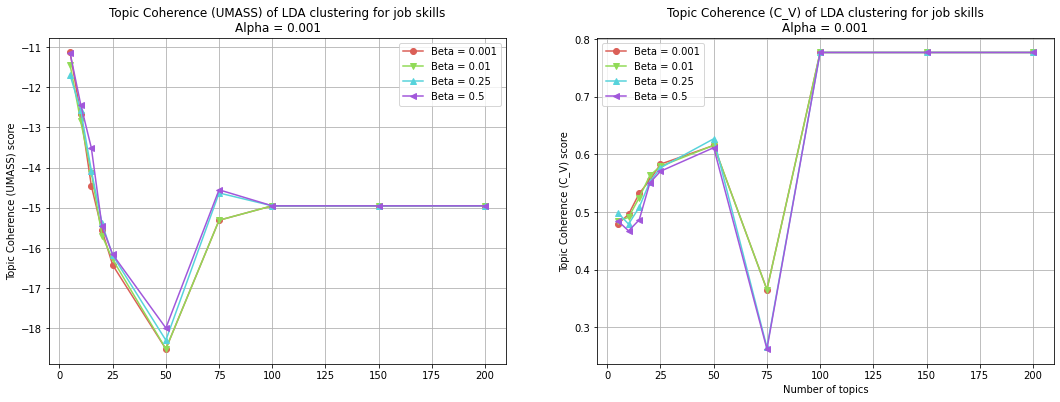

<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(1, 2, 1)
<ipython-input-64-dc66f18108fb>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(1, 2, 2)
<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be 

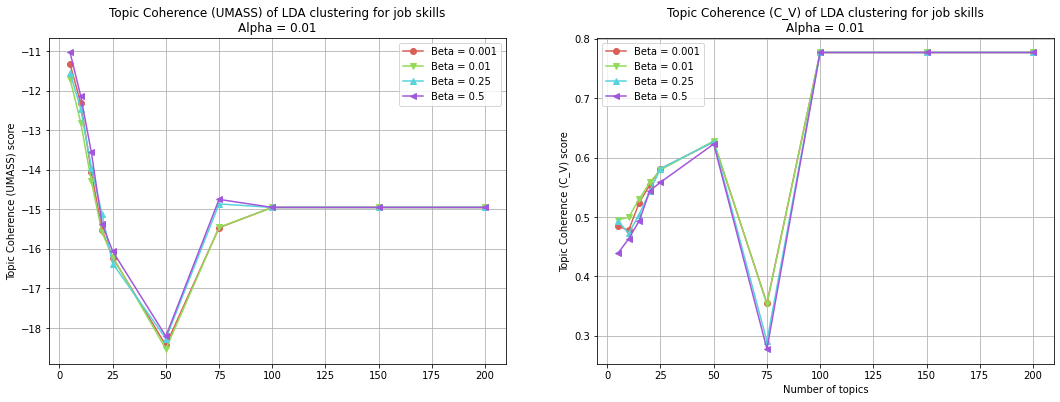

<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(1, 2, 1)
<ipython-input-64-dc66f18108fb>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(1, 2, 2)
<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be 

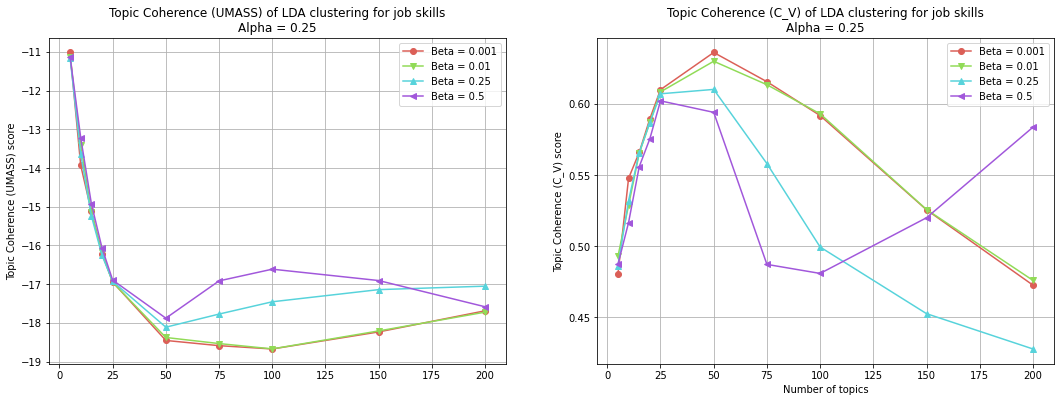

<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(1, 2, 1)
<ipython-input-64-dc66f18108fb>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.subplot(1, 2, 2)
<ipython-input-64-dc66f18108fb>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be 

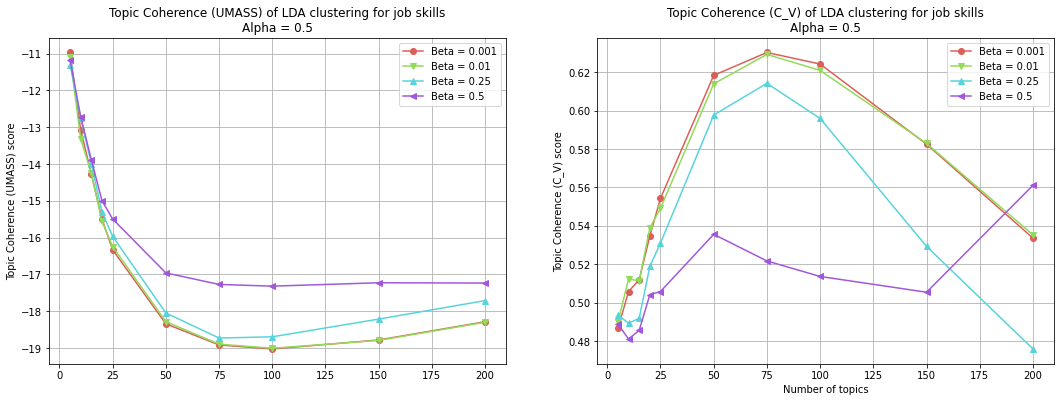

In [64]:
palette = sns.color_palette("hls", n_colors=len(beta_range))

# The higher the better

for ida, alpha in enumerate(alpha_range):
    fig = plt.figure(figsize=(18, 6))
    for idx, beta in enumerate(beta_range):
        # Plot UMASS coherence
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(
            tuning_result_df["n_topics"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            tuning_result_df["coherence_umass"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
        ax1.set_ylabel("Topic Coherence (UMASS) score")
        # plt.xticks(np.unique(model_result_df["min_samples"]))
        ax1.set_title(
            "Topic Coherence (UMASS) of LDA clustering for job skills\n"
            + "Alpha = "
            + str(alpha)
        )
        ax1.legend(loc="best")

        # Plot C_V coherence
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(
            tuning_result_df["n_topics"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            tuning_result_df["coherence_cv"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
        ax2.set_ylabel("Topic Coherence (C_V) score")
        # plt.xticks(np.unique(model_result_df["min_samples"]))
        ax2.set_title(
            "Topic Coherence (C_V) of LDA clustering for job skills\n"
            + "Alpha = "
            + str(alpha)
        )
        ax2.set_xlabel("Number of topics")
        # plt.yticks(np.unique(model_result_df["number_clusters"]))

        ax2.legend(loc="best")
    ax1.grid()
    ax2.grid()

    # Saving plot as image
    fig.savefig(
        RESULT_DIR
        + "lda/"
        + "skill_lda_coherence_alpha-"
        + str(alpha)
        + "_plot.png",
        #     bbox_inches="tight",
        #     dpi=150,
    )

    # Show plot
    plt.show()

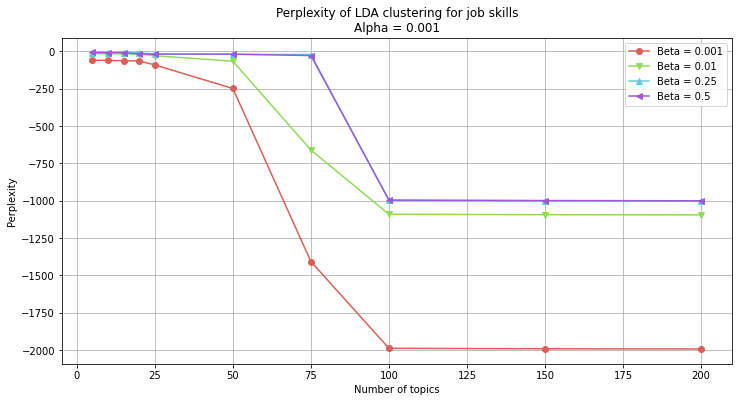

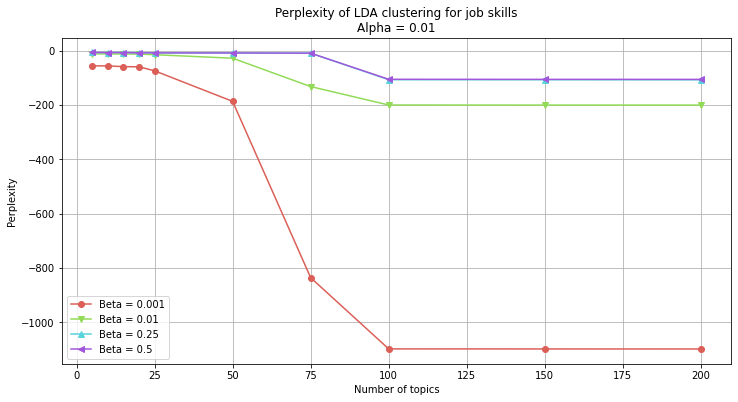

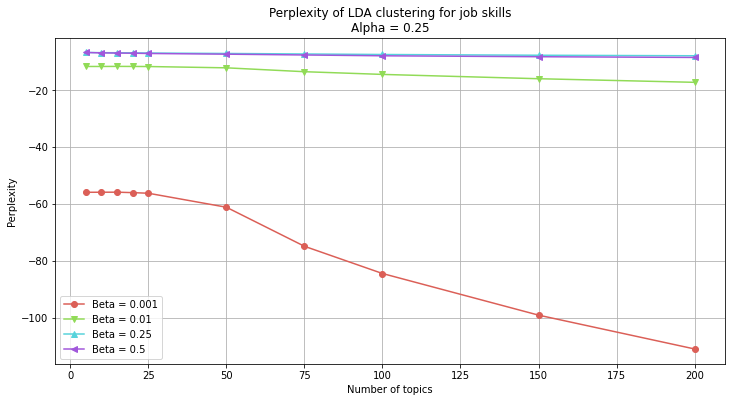

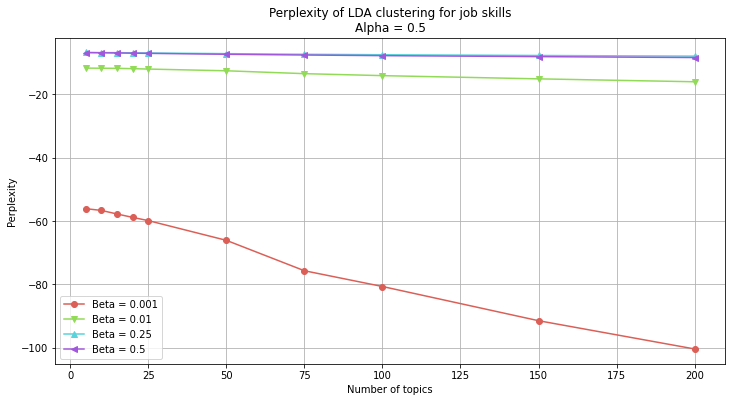

In [66]:
palette = sns.color_palette("hls", n_colors=len(beta_range))

# The higher the better
for ida, alpha in enumerate(alpha_range):
    fig = plt.figure(figsize=(12, 6))
    for idx, beta in enumerate(beta_range):
        plt.plot(
            tuning_result_df["n_topics"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            tuning_result_df["perplexity"].loc[
                (tuning_result_df["beta"] == beta)
                & (tuning_result_df["alpha"] == alpha)
            ],
            label="Beta = " + str(beta),
            color=palette[idx],
            marker=marker_list[idx],
        )
    plt.xlabel("Number of topics")
    # plt.yticks(np.unique(model_result_df["number_clusters"]))
    plt.ylabel("Perplexity")
    # plt.xticks(np.unique(model_result_df["min_samples"]))
    plt.title("Perplexity of LDA clustering for job skills\n" + "Alpha = " + str(alpha))
    plt.legend(loc="best")
    plt.grid()

    # Saving plot as image
    fig.savefig(
        RESULT_DIR + "lda/" + "skill_lda_perplexity_alpha-" + str(alpha) + "_plot.png",
        #     bbox_inches="tight",
        #     dpi=150,
    )

    # Show plot
    plt.show()

In [76]:
# Select the LDA model with optimal number of topics
# best_index = np.argmax(tuning_result_df["coherence_cv"].values)
best_index = int(
    np.where(
        (np.array(tuning_result["alpha"]) == 0.001)
        & (np.array(tuning_result["beta"]) == 0.001)
        & (np.array(tuning_result["n_topics"]) == 50)
    )[0]
)
print("Index of best coherence score", best_index)
best_n_topics = tuning_result_df["n_topics"][best_index]
best_alpha = tuning_result_df["alpha"][best_index]
best_beta = tuning_result_df["beta"][best_index]

print(
    f"Optimal number of topics = {best_n_topics}, best alpha = {best_alpha}, best beta = {best_beta}"
)
# best_lda_model = build_lda_model(
#     dictionary=id2word,
#     corpus=lda_corpus,
#     n_topics=best_n_topics,
#     alpha=best_alpha,
#     beta=best_beta,
# )
best_lda_model = model_list[best_index]

Index of best coherence score 80
Optimal number of topics = 50, best alpha = 0.001, best beta = 0.001


In [77]:
# Get topic weights
topic_weights = []
for i, row_list in tqdm(
    iterable=enumerate(best_lda_model[lda_corpus]),
    desc="Get LDA topic weights",
    total=len(best_lda_model[lda_corpus]),
):
    #     print(i)
    #     print(row_list)
#     if len(row_list) > 0:
    topic_weights.append([w for i, w in row_list])
#     else:
#         topic_weights.append([0])
#     print()

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

Get LDA topic weights: 100%|█████████████████████████████████████████████████| 257205/257205 [00:43<00:00, 5904.81it/s]


In [78]:
arr.shape

(257205, 50)

In [79]:
np.asarray(topic_weights).shape

(257205, 50)

In [80]:
np.asarray(topic_weights)[:10, :10]

array([[2.4693352e-04, 2.4693352e-04, 2.4693352e-04, 4.9410400e-01,
        2.4693352e-04, 2.4693352e-04, 2.4693352e-04, 2.4693352e-04,
        2.4693352e-04, 2.4693352e-04],
       [3.2786981e-04, 3.2786981e-04, 3.2786981e-04, 3.2786981e-04,
        3.2786981e-04, 3.2786981e-04, 3.2786981e-04, 3.2819647e-01,
        3.2786981e-04, 3.2786981e-04],
       [3.2786990e-04, 3.2786990e-04, 3.2786990e-04, 3.2786990e-04,
        3.2786990e-04, 3.2786990e-04, 3.2786990e-04, 3.2786990e-04,
        3.2786990e-04, 3.2786990e-04],
       [3.2786964e-04, 3.2786964e-04, 3.2786964e-04, 3.2786964e-04,
        3.2786964e-04, 3.2786964e-04, 3.2786964e-04, 3.2786964e-04,
        3.2786964e-04, 3.2786964e-04],
       [3.2787092e-04, 3.2787092e-04, 3.2787092e-04, 3.2787092e-04,
        3.2787092e-04, 3.2787092e-04, 3.2787092e-04, 3.2787092e-04,
        3.2787092e-04, 3.2819462e-01],
       [3.2788841e-04, 3.2788841e-04, 3.2788841e-04, 3.2788841e-04,
        3.2788841e-04, 3.2788841e-04, 3.2788841e-04, 3.27

In [81]:
# topic_num

In [82]:
np.unique(topic_num)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int64)

In [ ]:
# Reduce dimensionality using t-SNE algorithm
# Compute PCA components
pca_datapoint, _, _ = compute_cluster_visualization(
    X=arr, pca=True, tsne=False, compute_umap=False, seed=SEED
)

In [ ]:
# Compute t-SNE components
_, _, tsne_datapoint = compute_cluster_visualization(
    X=arr, pca=False, tsne=True, compute_umap=False, seed=SEED, perplexity=30
)

In [ ]:
# Compute UMAP components
_, umap_datapoint, _ = compute_cluster_visualization(
    X=arr, pca=False, tsne=False, compute_umap=True, seed=SEED, perplexity=7
)

In [ ]:
# Save PCA and t-SNE dimensionality reduced data to file
np.save(OUTPUT_DIR + "visualization/" + "skill_lda_pca_datapoints", pca_datapoint)
np.save(OUTPUT_DIR + "visualization/" + "skill_lda_umap_datapoints", umap_datapoint)
np.save(OUTPUT_DIR + "visualization/" + "skill_lda_tsne_datapoints", tsne_datapoint)

In [ ]:
plot_title = (
    "LDA topics visualization on job skills (number of topics = "
    + str(best_n_topics)
    + ")"
)
plot_filename = (
    RESULT_DIR + "lda/" + "skill_lda_optimal-cluster-visualization-topics.png"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
# colors = cm.nipy_spectral(best_labels.astype(float) / best_k)
colors = topic_num

# Visualize clusters with PCA, UMAP, and t-SNE
visualize_cluster(
    plot_title,
    (12, 15),
    colors,
    palette,
    4,
    pca_datapoint,
    tsne_datapoint,
    umap_datapoint,
    pca=True,
    tsne=True,
    compute_umap=True,
    save_plots=True,
    plot_file=plot_filename,
)

In [83]:
# Finding the dominant topic in each document
def format_topics_sentences(ldamodel=best_lda_model, corpus=lda_corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm(
        iterable=enumerate(best_lda_model[corpus]),
        desc="Find dominant topic of each document",
        total=len(best_lda_model[corpus]),
    ):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    # Add original text to the end of the output
    contents = pd.Series(texts)
#     sent_topics_df.reset_index(inplace=True)
#     contents.reset_index(inplace=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(
    ldamodel=best_lda_model, corpus=lda_corpus, texts=doc_list
)

Find dominant topic of each document: 100%|████████████████████████████████████| 257205/257205 [44:09<00:00, 97.09it/s]


In [84]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,3.0,0.4941,"program, year, civil, investment, student, soc...",ameria investment consult company
1,20.0,0.3282,"knowledge, high, strategy, material, reporting...",require high level
2,18.0,0.3282,"responsible, require, developer, java, health,...",provide highly responsible
3,39.0,0.9839,"include, international, legal, staff, social, ...",complex staff assistance
4,30.0,0.6561,"financial, manage, ensure, visit, schedule, ch...",chief financial officer
...,...,...,...,...
257200,14.0,0.4883,"system, solution, operational, cjsc, maintenan...",ra financial system
257201,21.0,0.3282,"education, daily, practice, cycle, operating, ...",high legal education
257202,20.0,0.4883,"knowledge, high, strategy, material, reporting...",high pressure environment
257203,31.0,0.3282,"work, information, technology, establish, paym...",professional work experience


In [85]:
# Format
df_dominant_topic = df_topic_sents_keywords.copy(deep=True)
df_dominant_topic.reset_index(drop=True, inplace=True)
df_dominant_topic.columns = [
#     "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

print(df_dominant_topic.shape, df_topic_sents_keywords.shape)

(257205, 4) (257205, 4)


In [86]:
# Show
df_dominant_topic

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,3.0,0.4941,"program, year, civil, investment, student, soc...",ameria investment consult company
1,20.0,0.3282,"knowledge, high, strategy, material, reporting...",require high level
2,18.0,0.3282,"responsible, require, developer, java, health,...",provide highly responsible
3,39.0,0.9839,"include, international, legal, staff, social, ...",complex staff assistance
4,30.0,0.6561,"financial, manage, ensure, visit, schedule, ch...",chief financial officer
...,...,...,...,...
257200,14.0,0.4883,"system, solution, operational, cjsc, maintenan...",ra financial system
257201,21.0,0.3282,"education, daily, practice, cycle, operating, ...",high legal education
257202,20.0,0.4883,"knowledge, high, strategy, material, reporting...",high pressure environment
257203,31.0,0.3282,"work, information, technology, establish, paym...",professional work experience


In [87]:
df_clusters = pd.concat(
    [
        skill_docs,
        df_dominant_topic[["Dominant_Topic", "Topic_Perc_Contrib", "Keywords"]],
    ],
    axis=1,
)
print(df_clusters.shape)
df_clusters

(257205, 12)


,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]",3.0,0.4941,"program, year, civil, investment, student, soc..."
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]",20.0,0.3282,"knowledge, high, strategy, material, reporting..."
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]",18.0,0.3282,"responsible, require, developer, java, health,..."
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]",39.0,0.9839,"include, international, legal, staff, social, ..."
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]",30.0,0.6561,"financial, manage, ensure, visit, schedule, ch..."
...,...,...,...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]",14.0,0.4883,"system, solution, operational, cjsc, maintenan..."
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]",21.0,0.3282,"education, daily, practice, cycle, operating, ..."
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]",20.0,0.4883,"knowledge, high, strategy, material, reporting..."
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]",31.0,0.3282,"work, information, technology, establish, paym..."


In [89]:
# Reorganize the dataframe
# df_clusters.insert(4, "n_clusters", best_n_topics)
df_clusters['n_clusters'] = best_n_topics
df_clusters.rename(
    columns={
        "Dominant_Topic": "title_cluster_label",
        "Topic_Perc_Contrib": "topic_perc_contrib",
        "Keywords": "topic_keywords",
    },
    inplace=True,
)

df_clusters = df_clusters[[
    "row_id",
    "key_id",
    "job_id",
    "skill_id",
    "column_id",
    "column_type",
    "skill",
    "skill_lemma",
    "skill_token",
    "n_clusters",
    "title_cluster_label",
    "topic_perc_contrib",
    "topic_keywords",
]]
df_clusters[['title_cluster_label']] = df_clusters[['title_cluster_label']].applymap(int)
df_clusters

,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token,n_clusters,title_cluster_label,topic_perc_contrib,topic_keywords
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]",50,3,0.4941,"program, year, civil, investment, student, soc..."
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]",50,20,0.3282,"knowledge, high, strategy, material, reporting..."
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]",50,18,0.3282,"responsible, require, developer, java, health,..."
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]",50,39,0.9839,"include, international, legal, staff, social, ..."
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]",50,30,0.6561,"financial, manage, ensure, visit, schedule, ch..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]",50,14,0.4883,"system, solution, operational, cjsc, maintenan..."
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]",50,21,0.3282,"education, daily, practice, cycle, operating, ..."
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]",50,20,0.4883,"knowledge, high, strategy, material, reporting..."
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]",50,31,0.3282,"work, information, technology, establish, paym..."


In [90]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in tqdm(
    iterable=sent_topics_outdf_grpd,
    desc="Find representative document for each topic",
    total=len(sent_topics_outdf_grpd),
):
    sent_topics_sorted_df = pd.concat(
        [
            sent_topics_sorted_df,
            grp.sort_values(["Perc_Contribution"], ascending=[0]).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

print(sent_topics_sorted_df.shape)

Find representative document for each topic: 100%|████████████████████████████████████| 50/50 [00:00<00:00, 218.34it/s]

(50, 4)


In [91]:
# Show
sent_topics_sorted_df

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9761,"package, candidate, source, case, study, super...",food safety
1,1.0,0.9879,"excellent, communication, customer, document, ...",answer customer phone call
2,2.0,0.9879,"effective, banking, national, world, large, vi...",world vision armenias national
3,3.0,0.9839,"program, year, civil, investment, student, soc...",successfully engage civil society
4,4.0,0.9879,"security, llc, coordinate, partner, institutio...",assist iatp partner institution
5,5.0,0.9839,"bank, engineer, use, responsibility, translati...",photojournalist ruben mangasaryan
6,6.0,0.9879,"personality, policy, resource, human, person, ...",french journalist laurence ritter
7,7.0,0.9761,"relevant, level, issue, administration, site, ...",virage logic
8,8.0,0.9838,"experience, university, implement, time, tool,...",time start february
9,9.0,0.9903,"server, training, operation, group, result, in...",increase search engine generate traffic


In [94]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,3.0,0.4941,"program, year, civil, investment, student, soc...",ameria investment consult company
1,20.0,0.3282,"knowledge, high, strategy, material, reporting...",require high level
2,18.0,0.3282,"responsible, require, developer, java, health,...",provide highly responsible
3,39.0,0.9839,"include, international, legal, staff, social, ...",complex staff assistance
4,30.0,0.6561,"financial, manage, ensure, visit, schedule, ch...",chief financial officer
...,...,...,...,...
257200,14.0,0.4883,"system, solution, operational, cjsc, maintenan...",ra financial system
257201,21.0,0.3282,"education, daily, practice, cycle, operating, ...",high legal education
257202,20.0,0.4883,"knowledge, high, strategy, material, reporting...",high pressure environment
257203,31.0,0.3282,"work, information, technology, establish, paym...",professional work experience


In [95]:
# Topic distribution across documents

# Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords["Dominant_Topic"].value_counts()
topic_counts = (
    df_topic_sents_keywords[["Dominant_Topic", 0]]
    .groupby(["Dominant_Topic"])
    .count()
)
print(topic_counts.shape, end=" ")
topic_counts.columns = ["Num_Documents"]
# topic_counts

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts / topic_counts.sum(), 4)
print(topic_contribution.shape, end=" ")
topic_contribution.columns = ["Perc_Documents"]
# topic_contribution

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[["Dominant_Topic", "Topic_Keywords"]]
topic_num_keywords.drop_duplicates(inplace=True)
# topic_num_keywords.set_index(topic_num_keywords['Dominant_Topic'], inplace=True)
# topic_num_keywords.rename(index="")
topic_num_keywords.sort_values(by=["Dominant_Topic"], ascending=True, inplace=True)
topic_num_keywords.reset_index(drop=True, inplace=True)
print(topic_num_keywords.shape, end=" ")
# topic_num_keywords

# Concatenate Column wise
# topic_counts.reset_index(inplace=True, drop=True)
# topic_contribution.reset_index(inplace=True, drop=True)
# topic_num_keywords.reset_index(inplace=True, drop=True)

df_dominant_topics = pd.concat(
    [topic_num_keywords, topic_counts, topic_contribution], axis=1
)

# Change Column names
df_dominant_topics.columns = [
    "Dominant_Topic",
    "Topic_Keywords",
    "Num_Documents",
    "Perc_Documents",
]

# df_dominant_topics.dropna(subset=['Num_Documents'], inplace=True)
df_dominant_topics.sort_values(by=["Num_Documents"], ascending=False, inplace=True)
df_dominant_topics.reset_index(drop=True, inplace=True)

print(df_dominant_topics.shape)

(50, 1) (50, 1) (50, 2) (50, 4)


<ipython-input-95-99ff2c7287bc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_num_keywords.drop_duplicates(inplace=True)
<ipython-input-95-99ff2c7287bc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_num_keywords.sort_values(by=["Dominant_Topic"], ascending=True, inplace=True)


In [96]:
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"package, candidate, source, case, study, super...",20233,0.0787
1,45.0,"skill, problem, solve, public, specialist, law...",16652,0.0647
2,31.0,"work, information, technology, establish, paym...",11333,0.0441
3,49.0,"language, english, provide, test, cash, build,...",10128,0.0394
4,10.0,"software, computer, product, development, draf...",7477,0.0291
5,11.0,"service, design, database, user, interface, ar...",6930,0.0269
6,41.0,"project, management, personal, center, integra...",6523,0.0254
7,19.0,"degree, web, armenian, different, regional, gr...",6278,0.0244
8,14.0,"system, solution, operational, cjsc, maintenan...",6186,0.0241
9,8.0,"experience, university, implement, time, tool,...",6067,0.0236


In [97]:
X = skill_embeddings
best_labels = df_dominant_topic["Dominant_Topic"].values
model_validation = {"n_topics": [best_n_topics], "alpha": [best_alpha], "beta": [best_alpha]}

In [98]:
model_validation["silhouette"] = []
model_validation["silhouette_error"] = []

try:
    silhouette = metrics.silhouette_score(
        X, best_labels, sample_size=10000, random_state=SEED, n_jobs=-1
    )
    model_validation["silhouette_error"].append("None")
except Exception as e:
    print(e)
    silhouette = -1.1
    model_validation["silhouette_error"].append(e)
model_validation["silhouette"].append(silhouette)

In [99]:
model_validation["calinski_harabasz"] = []
model_validation["calinski_harabasz_error"] = []

try:
    calinski_harabasz = metrics.calinski_harabasz_score(X, best_labels)
    model_validation["calinski_harabasz_error"].append("None")
except Exception as e:
    print(e)
    calinski_harabasz = -1.1
    model_validation["calinski_harabasz_error"].append(e)
model_validation["calinski_harabasz"].append(calinski_harabasz)

In [100]:
model_validation["davies_bouldin"] = []
model_validation["davies_bouldin_error"] = []

try:
    davies_bouldin = metrics.davies_bouldin_score(X, best_labels)
    model_validation["davies_bouldin_error"].append("None")
except Exception as e:
    print(e)
    davies_bouldin = -1.1
    model_validation["davies_bouldin_error"].append(e)
model_validation["davies_bouldin"].append(davies_bouldin)

In [101]:
model_validation["silhouette_corr"] = []
model_validation["silhouette_corr_error"] = []

try:
    silhouette = metrics.silhouette_score(
        X,
        best_labels,
        sample_size=10000,
        random_state=SEED,
        n_jobs=-1,
        metric="correlation",
    )
    model_validation["silhouette_corr_error"].append("None")
except Exception as e:
    print(e)
    silhouette = -1.1
    model_validation["silhouette_corr_error"].append(e)
model_validation["silhouette_corr"].append(silhouette)

In [102]:
# Display validation results
model_validation_df = pd.DataFrame(model_validation)
model_validation_df

,n_topics,alpha,beta,silhouette,silhouette_error,calinski_harabasz,calinski_harabasz_error,davies_bouldin,davies_bouldin_error,silhouette_corr,silhouette_corr_error
0,50,0.001,0.001,-0.030851,None,1.246484,None,115.157041,None,0.0,None


In [103]:
# Save tuning results
model_validation_df.to_csv(
    RESULT_DIR + "lda/" + "skill_lda_model_validation.csv", index=False
)

In [110]:
pca_datapoint_raw = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_pca_datapoints.npy")
umap_datapoint_raw = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_umap_datapoints.npy")
tsne_datapoint_raw = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_tsne_datapoints.npy")

Start PCA 2021-05-21 18:32:44.119972
End PCA 2021-05-21 18:32:44.251271
PCA duration 0:00:00.131299

Start t-SNE 2021-05-21 18:32:44.252555
End t-SNE 2021-05-21 18:32:44.289674
t-SNE duration 0:00:00.037119

Start UMAP 2021-05-21 18:32:44.289674
End UMAP 2021-05-21 18:32:44.375966
UMAP duration 0:00:00.086292



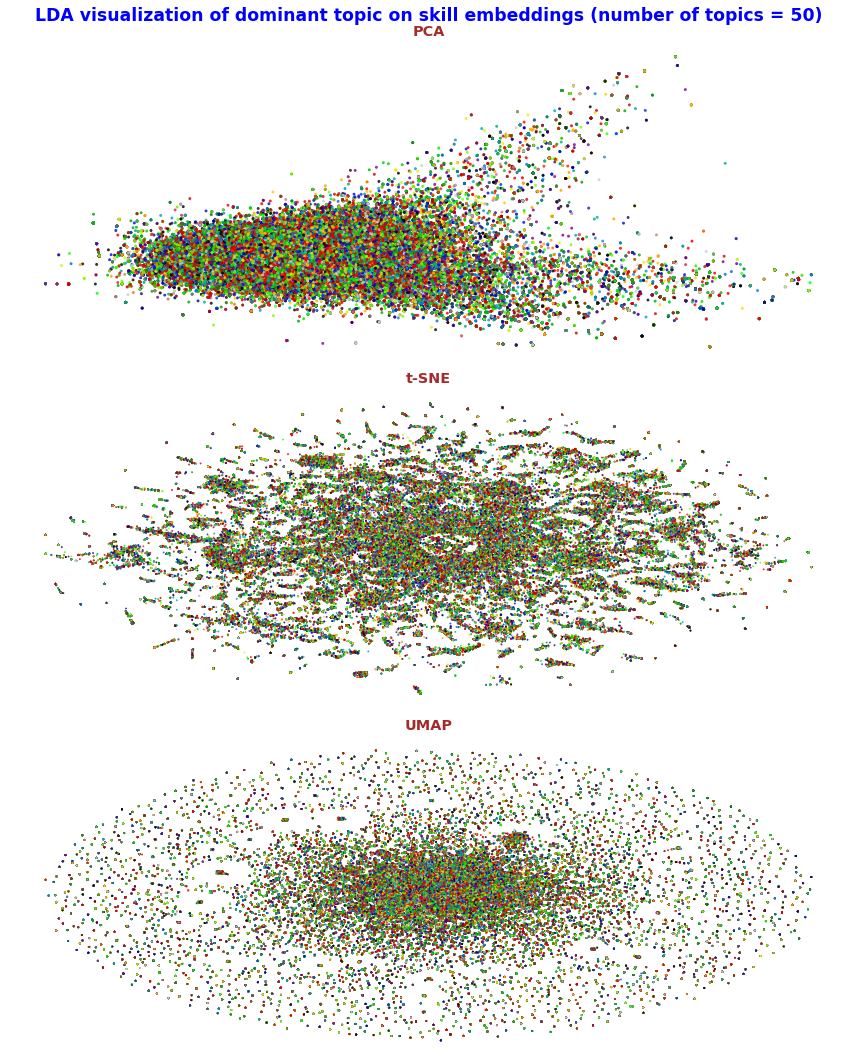

In [111]:
plot_title = (
    "LDA visualization of dominant topic on skill embeddings (number of topics = "
    + str(best_n_topics)
    + ")"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
plot_filename = (
    RESULT_DIR + "lda/" + "skill_lda_optimal-cluster-visualization-embeddings.png"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
# colors = cm.nipy_spectral(best_labels.astype(float) / best_k)
colors = best_labels

# Visualize clusters with PCA, UMAP, and t-SNE
visualize_cluster(
    plot_title,
    (12, 15),
    colors,
    palette,
    4,
    pca_datapoint_raw,
    tsne_datapoint_raw,
    umap_datapoint_raw,
    pca=True,
    tsne=True,
    compute_umap=True,
    save_plots=True,
    plot_file=plot_filename,
)

## Save cluster results to file

In [105]:
sent_topics_sorted_df.to_csv(
    RESULT_DIR + "lda/" + "skill_lda_optimal-represent-doc-per-topic.csv", index=False
)

In [106]:
df_dominant_topics.to_csv(
    RESULT_DIR + "lda/" + "skill_lda_optimal-topic-distribution.csv", index=False
)

In [107]:
df_clusters.to_csv(
    RESULT_DIR + "lda/" + "skill_lda_optimal-cluster-labels.csv", index=False
)

In [108]:
# Save tuple of model sets
pickle.dump(
    (
        arr,
        sent_topics_sorted_df,
        df_dominant_topics,
        df_clusters,
    ),
    open(RESULT_DIR + "lda/" + "skill_lda_model_topic_list.pkl", "wb"),
)